In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
vaccination_df = pd.read_csv('./COVID19_vaccination_doses_timeline_v202206.csv', delimiter=';')
hospitalisierung_df = pd.read_csv('./Hospitalisierung.csv', delimiter=';')
timeline_df = pd.read_csv('./CovidFaelle_Timeline.csv', delimiter=';')

In [7]:
vaccination_df = vaccination_df[['date', 'doses_administered_cumulative']]
hospitalisierung_df = hospitalisierung_df[['Meldedatum', 'IntensivBettenBelCovid19', 'NormalBettenBelCovid19']]
timeline_df = timeline_df[['Time', 'AnzahlTotTaeglich']]

In [8]:
%%capture
timeline_df['Time'] = timeline_df['Time'].str.strip('00:00:00').str.strip(' ')
timeline_df['Time'] = pd.to_datetime(timeline_df['Time'])

hospitalisierung_df['Meldedatum'] = hospitalisierung_df['Meldedatum'].str.strip('00:00:00').str.strip(' ')
hospitalisierung_df['Meldedatum'] = pd.to_datetime(hospitalisierung_df['Meldedatum'])

vaccination_df['date'] = vaccination_df['date'].str.slice(start=0, stop=10)
vaccination_df['date'] = pd.to_datetime(vaccination_df['date'])

In [9]:
timeline_df.sample(5)


,Time,AnzahlTotTaeglich
7672,2022-03-04,9
3987,2021-03-30,0
5183,2021-07-28,0
9551,2022-08-10,3
4624,2021-02-06,1


In [10]:
hospitalisierung_df.sample(5)

,Meldedatum,IntensivBettenBelCovid19,NormalBettenBelCovid19
1957,2021-07-08,1,3
1560,2021-06-29,2,4
275,2021-02-20,41,149
2517,2021-02-10,5,9
1244,2021-05-28,8,15


In [11]:
vaccination_df.sample(5)

,date,doses_administered_cumulative
169900,2022-05-25,106276
189151,2022-07-23,45271
211444,2022-09-28,0
176873,2022-06-15,287
129759,2022-01-24,6


In [12]:
hospitalisierung_df = hospitalisierung_df.groupby(['Meldedatum']).sum()
vaccination_df = vaccination_df.groupby(['date']).sum()
timeline_df = timeline_df.groupby(['Time']).sum()

In [13]:
timeline_df.index.names = ['date']
hospitalisierung_df.index.names = ['date']

In [14]:
timeline_df.sample(5)

,AnzahlTotTaeglich
date,
2021-09-20,22
2022-09-08,28
2020-06-27,6
2021-04-13,66
2021-08-25,12


In [15]:
hospitalisierung_df.sample(5)

,IntensivBettenBelCovid19,NormalBettenBelCovid19
date,,
2021-04-30,1012,2308
2021-07-02,570,2550
2022-12-09,94,1742
2022-05-16,130,1402
2022-02-04,430,5554


In [16]:
vaccination_df.sample(5)

,doses_administered_cumulative
date,
2022-05-15,36884000
2021-01-01,10594
2022-01-20,34931392
2022-03-08,36412570
2021-01-07,23144


In [17]:
merged = pd.merge(hospitalisierung_df, timeline_df, on='date', how='outer')
merged = merged.sort_values(by=['date'])

vaccine_end_of_month = vaccination_df.groupby(['date']).sum()
vaccines_month = vaccine_end_of_month.iloc[vaccine_end_of_month.reset_index().groupby(vaccine_end_of_month.index.to_period('M'))['date'].idxmax()]

merged = pd.merge(merged, vaccines_month, on='date', how='outer')

In [18]:
month_grouped = merged.groupby([merged.index.year, merged.index.month]).sum()
month_grouped['dates'] = month_grouped.index

new_col_list = ['year', 'month']
for n, col in enumerate(new_col_list):
    month_grouped[col] = month_grouped['dates'].apply(lambda date: date[n])

month_grouped = month_grouped.drop('dates', axis=1)
month_grouped["dates"] = month_grouped["year"].astype('string') + '-' + month_grouped["month"].astype('string')

del month_grouped['year']
del month_grouped['month']

In [19]:
month_grouped = month_grouped.droplevel(0)
month_grouped = month_grouped.reset_index(drop=True)
month_grouped = month_grouped.set_index('dates')

In [20]:
month_grouped.rename(columns={'IntensivBettenBelCovid19': 'Intensive_beds'}, inplace=True)
month_grouped.rename(columns={'NormalBettenBelCovid19': 'Normal_beds'}, inplace=True)
month_grouped.rename(columns={'AnzahlTotTaeglich': 'Deaths'}, inplace=True)
month_grouped.rename(columns={'doses_administered_cumulative': 'Vaccines_cumulative'}, inplace=True)

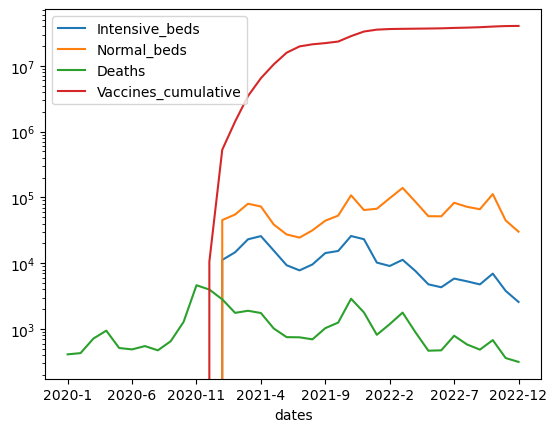

In [21]:
ax = month_grouped.plot.line(logy=True)

In [22]:
month_grouped_nan = month_grouped.replace(0, 'NaN')


In [23]:
month_grouped_nan.at['2020-11', 'Vaccines_cumulative'] = 0


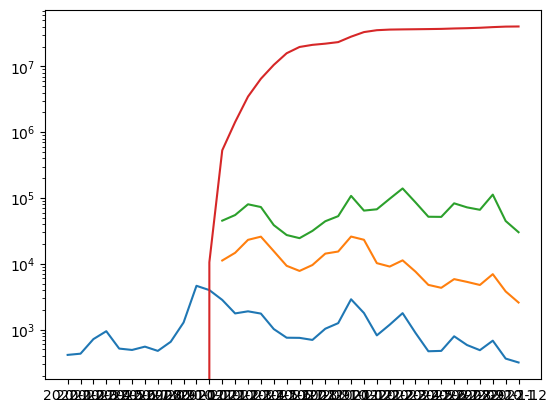

In [24]:
fig = plt.figure()
ax_nan = fig.add_subplot(111)

plt.plot(month_grouped_nan['Deaths'])
plt.plot(month_grouped_nan['Intensive_beds'][12:])
plt.plot(month_grouped_nan['Normal_beds'][12:])

plt.plot(month_grouped_nan['Vaccines_cumulative'][10:])
ax_nan.set_yscale('log')

In [25]:
month_grouped_nan_short = month_grouped_nan.drop(['2020-1', '2020-2', '2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8'])
# month_grouped_nan_short.index = month_grouped_nan_short.index.str.replace('-','xxx')
month_grouped_nan_short.index =  pd.to_datetime(month_grouped_nan_short.index, format='%Y-%m')

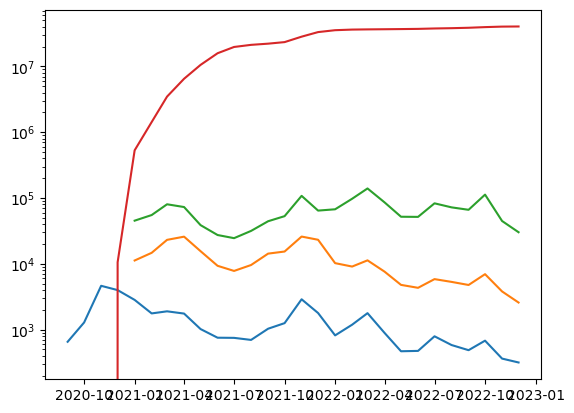

In [26]:
fig = plt.figure()
ax_nan = fig.add_subplot(111)

plt.plot(month_grouped_nan_short['Deaths'])
plt.plot(month_grouped_nan_short['Intensive_beds'][4:])
plt.plot(month_grouped_nan_short['Normal_beds'][4:])
plt.plot(month_grouped_nan_short['Vaccines_cumulative'][2:])

ax_nan.set_yscale('log')